<a href="https://colab.research.google.com/github/SigaFrente-NS/-Deep-Learning-network-training-code/blob/main/LSTMirr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import warnings  #ignorar avisos
warnings.filterwarnings('ignore')
import numpy as np
import math
from keras.initializers import HeNormal
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
file = r'/content/drive/MyDrive/DataVariados/INMET_CO_SERIE_TEMPORAL_0.CSV'
data1 = pd.read_csv(file, encoding='latin-1', sep=';')
data1 = data1.fillna(0)
data1.head()

,Date,Pressure,Radiation,Temperature,Humidity,Speed
0,01/01/2018,955.3,75.6,23.1,93.0,2.7
1,01/01/2018,956.2,292.2,23.9,90.0,1.6
2,01/01/2018,956.8,1102.8,26.1,79.0,1.8
3,01/01/2018,956.7,2230.3,28.6,70.0,3.7
4,01/01/2018,956.5,3038.4,29.6,61.0,4.6


In [ ]:
# Converter a coluna 'Date' para datetime e depois formatar para yyyy-mm-dd
data1['Date'] = pd.to_datetime(data1['Date'], format='%d/%m/%Y')

# Exibir no formato yyyy-mm-dd
data1['Date'] = data1['Date'].dt.strftime('%Y-%m-%d')
# Exibir o DataFrame resultante
print(data1)

             Date  Pressure  Radiation  Temperature  Humidity  Speed
0      2018-01-01     955.3       75.6         23.1      93.0    2.7
1      2018-01-01     956.2      292.2         23.9      90.0    1.6
2      2018-01-01     956.8     1102.8         26.1      79.0    1.8
3      2018-01-01     956.7     2230.3         28.6      70.0    3.7
4      2018-01-01     956.5     3038.4         29.6      61.0    4.6
...           ...       ...        ...          ...       ...    ...
22339  2022-11-19    1006.5        8.8         26.9      81.0    0.0
22340  2022-12-18    1004.4      523.4         27.4      74.0    0.0
22341  2022-12-19    1008.1     2024.5         28.6      70.0    0.0
22342  2022-12-19    1007.8     3149.6         30.1      70.0    0.0
22343  2022-12-31    1006.6     2723.4         29.8      75.0    0.0

[22344 rows x 6 columns]


In [ ]:
# Criação do DataFrame
data = pd.DataFrame(data1)

# Reorganizar as colunas com 'Radiation' na última posição
data = data[['Date','Humidity', 'Pressure', 'Speed', 'Temperature', 'Radiation']]


In [ ]:
# Criar variáveis derivadas
data['Radiation_diff'] = data['Radiation'].diff().fillna(0)
data['Radiation_ma'] = data['Radiation'].rolling(window=5).mean().fillna(method='bfill')


In [ ]:

# Separar em entradas (X) e alvo (y)
features = ['Humidity', 'Pressure', 'Speed', 'Temperature', 'Radiation_diff', 'Radiation_ma']
target = 'Radiation'
X = data[features]
y = data[[target]]

In [ ]:
# Normalização dos dados
scaler_X =  MinMaxScaler()
scaler_y =  MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_scaled[:5]

array([[0.99930686, 0.31275168, 0.15      , 0.99317213, 0.4718742 ,
        0.35520476],
       [0.9990098 , 0.31304633, 0.08888889, 0.99325141, 0.50453058,
        0.35520476],
       [0.99792059, 0.31324276, 0.1       , 0.99346943, 0.59408687,
        0.35520476],
       [0.99702941, 0.31321002, 0.20555556, 0.99371717, 0.6418653 ,
        0.35520476],
       [0.99613823, 0.31314454, 0.25555556, 0.99381627, 0.59370995,
        0.35520476]])

In [ ]:
# Divisão em conjunto de treino e teste
train_size = int(len(data) * 0.9)
train_X, test_X = X_scaled[:train_size], X_scaled[train_size:]
train_y, test_y = y_scaled[:train_size], y_scaled[train_size:]

In [ ]:
# Função para criar sequência temporal
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 10  # Tamanho da janela
train_X_seq, train_y_seq = create_dataset(train_X, train_y, time_steps)
test_X_seq, test_y_seq = create_dataset(test_X, test_y, time_steps)
train_X_seq.shape, train_y_seq.shape, test_X_seq.shape, test_y_seq.shape

((20099, 10, 6), (20099, 1), (2225, 10, 6), (2225, 1))

In [ ]:
# 2. Criação do Modelo LSTM
model = Sequential([
    GRU(256, activation='relu',kernel_regularizer=regularizers.l2(0.01), return_sequences=True, input_shape=(time_steps, train_X_seq.shape[2])),
    Dropout(0.2),
    GRU(128, activation='relu', return_sequences=True),
    Dropout(0.2),
    GRU(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

In [ ]:
# 3. Treinamento do Modelo
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    train_X_seq, train_y_seq,
    epochs=50, batch_size=32,
    validation_data=(test_X_seq, test_y_seq),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - loss: 0.0770 - mae: 0.1827 - mse: 0.0516 - val_loss: 0.0115 - val_mae: 0.0720 - val_mse: 0.0078 - learning_rate: 0.0010
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - loss: 0.0187 - mae: 0.0963 - mse: 0.0154 - val_loss: 0.0145 - val_mae: 0.0841 - val_mse: 0.0121 - learning_rate: 0.0010
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - loss: 0.0159 - mae: 0.0893 - mse: 0.0137 - val_loss: 0.0077 - val_mae: 0.0595 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0147 - mae: 0.0870 - mse: 0.0129 - val_loss: 0.0110 - val_mae: 0.0794 - val_mse: 0.0095 - learning_rate: 0.0010
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - loss: 0.0144 - mae: 0.0870 - mse: 0.0129 - val_loss: 0.0121 - val_mae: 0.0852 - val_mse: 0.0107 - learning_rate: 0.0010
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - loss: 0.0148 - mae: 0.0876 - mse: 0.0133 - val_loss: 0.0074 - va

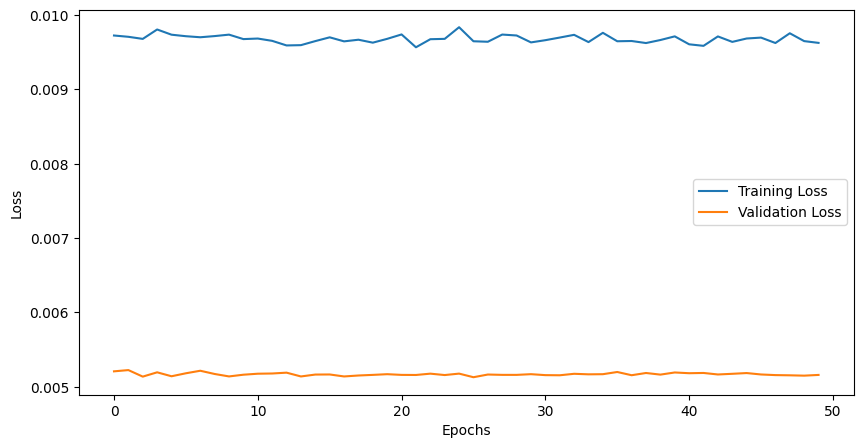

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 4. Avaliação do Modelo
y_pred_scaled = model.predict(test_X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(test_y_seq)

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


In [ ]:
# Calcular métricas de erro
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 295.66
MAE: 214.04
R²: 0.94


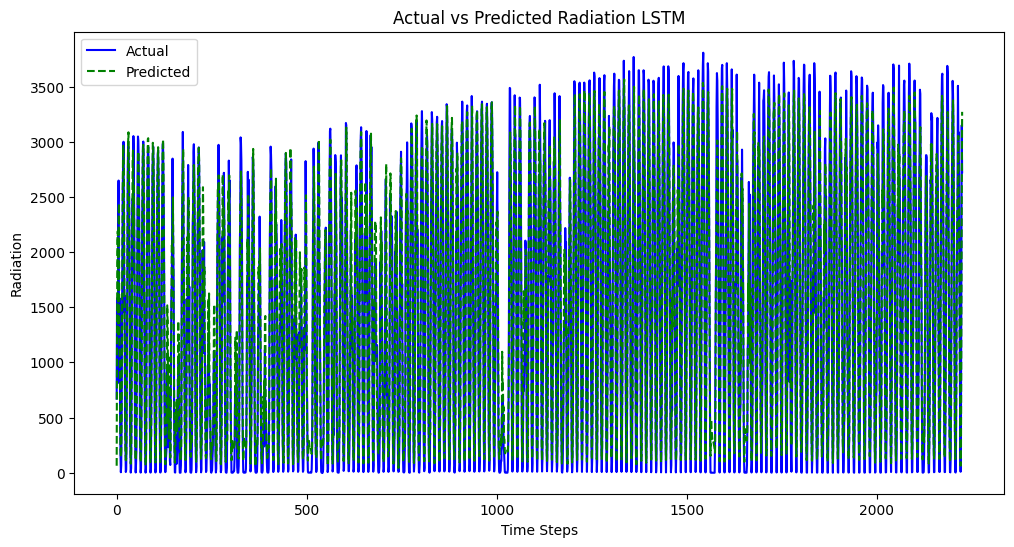

In [ ]:
# 5. Visualização dos Resultados
# Gráfico das previsões vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='Green', linestyle='--')
plt.title('Actual vs Predicted Radiation LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Radiation')
plt.legend()
plt.show()

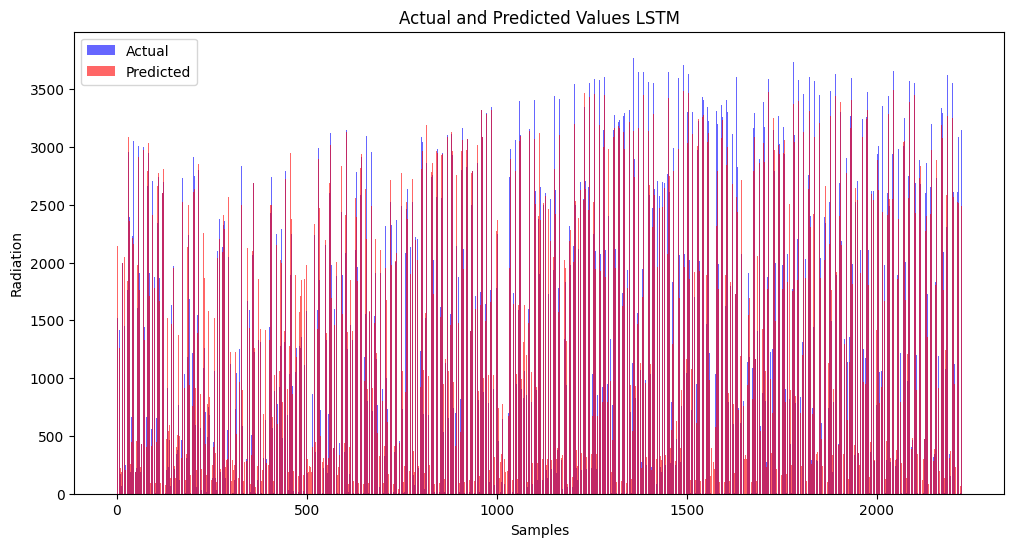

In [ ]:
# Gráfico de barras empilhadas
x = range(len(y_actual))
plt.figure(figsize=(12, 6))
plt.bar(x, y_actual.flatten(), color='blue', alpha=0.6, label='Actual')
plt.bar(x, y_pred.flatten(), color='red', alpha=0.6, label='Predicted')
plt.title('Actual and Predicted Values LSTM')
plt.xlabel('Samples')
plt.ylabel('Radiation')
plt.legend()
plt.show()

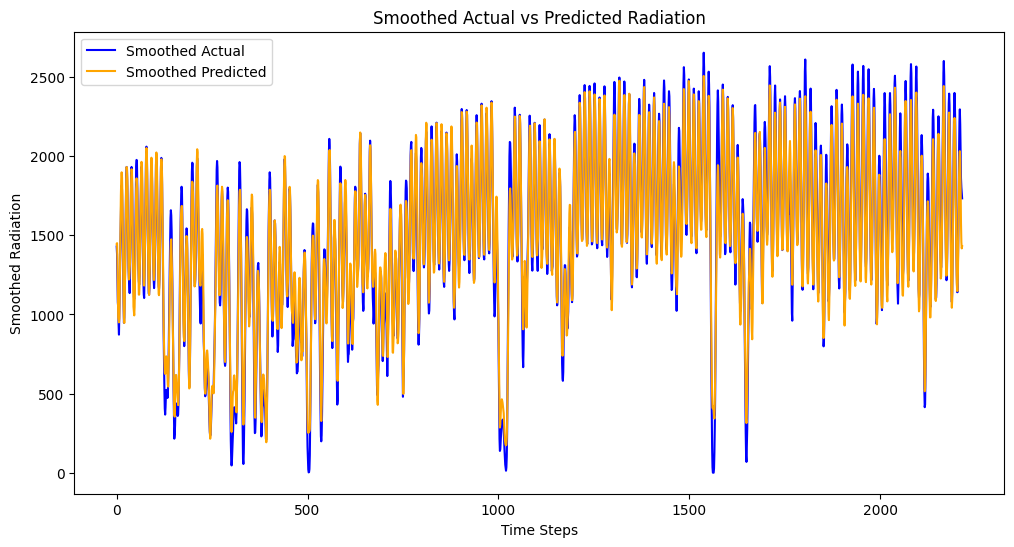

In [ ]:
# Supondo que y_actual e y_pred sejam arrays multidimensionais, você pode "achatar" as variáveis
y_actual = np.ravel(y_actual)  # Converte para array unidimensional
y_pred = np.ravel(y_pred)      # Converte para array unidimensional

# Aplicando a média móvel
window_size = 10  # Número de pontos para a média móvel
smoothed_actual = np.convolve(y_actual, np.ones(window_size)/window_size, mode='valid')
smoothed_pred = np.convolve(y_pred, np.ones(window_size)/window_size, mode='valid')

# Exibindo o gráfico
plt.figure(figsize=(12, 6))
plt.plot(smoothed_actual, label='Smoothed Actual', color='blue')
plt.plot(smoothed_pred, label='Smoothed Predicted', color='orange', linestyle='-')
plt.xlabel('Time Steps')
plt.ylabel('Smoothed Radiation')
plt.title('Smoothed Actual vs Predicted Radiation')
plt.legend()
plt.show()

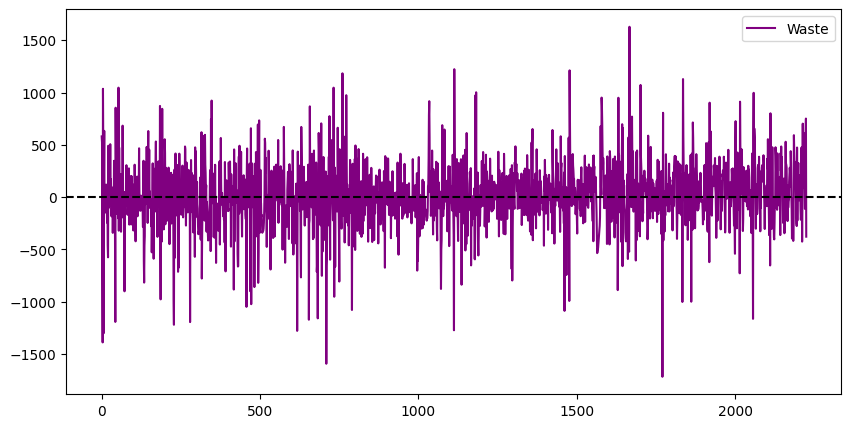

In [ ]:
# Gráfico de resíduos
residuals = y_actual - y_pred
plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Waste', color='purple')
plt.axhline(0, color='black', linestyle='--')
#plt.title('Waste Analysis')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(y_pred_scaled) #Ilustra as previsões nas 31 colunas
#Faremos o mesmo para os dados de treinnamento
original_data = np.concatenate([train_X[:,0], test_X[:len(y_pred_scaled ),0]])
fitted = np.concatenate([train_X[:,0], y_pred_scaled [:,0],])

df = pd.DataFrame({'Original': original_data,'Fitted':fitted, 'index':range(len(original_data))})
df.head()


,Original,Fitted,index
0,0.999307,0.999307,0
1,0.999010,0.999010,1
2,0.997921,0.997921,2
3,0.997029,0.997029,3
4,0.996138,0.996138,4
